In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset in Google Drive
data_path = '/content/drive/MyDrive/GTZAN Images/images_original/'




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Calculated Mean: tensor([0.4995, 0.4421, 0.5125])
Calculated Std Deviation: tensor([0.4475, 0.4688, 0.4241])


In [120]:
print(genre_to_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Filename: hiphop00045.png
Label (Numerical): 4
Class Name (Genre Name): hiphop


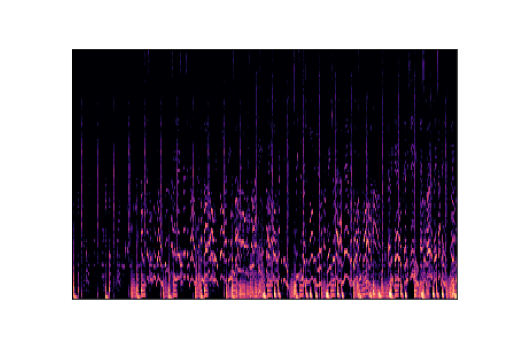

In [78]:
# Get a random index to select one image from the dataset
random_index = 455  # You can choose any index you want to check
img_path, label = dataset.samples[random_index]

# Get the filename from the image path
filename = img_path.split('/')[-1]

# Get the class name (genre name) using the numerical label
class_name = dataset.classes[label]

# Print the filename, label, and class name
print("Filename:", filename)
print("Label (Encoded):", label)
print("Class Name (Genre Name):", class_name)

# Load and display the image for verification
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [63]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32 * 108 * 72, 10)  # Adjust output size based on your dataset's classes

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 108 * 72)  # Adjust the flattening size based on the output size after convolutions
        x = self.fc(x)
        return x

# Move model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Define training function
def train(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    train_losses = []
    train_predictions = []
    train_labels = []

    for epoch in range(epochs):
        running_loss = 0.0
        epoch_losses = []  # List to store loss for each batch in the epoch

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Store predictions and labels
            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.tolist())
            train_labels.extend(labels.tolist())

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss}")

    return train_losses, train_predictions, train_labels

# Define validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_losses = []
    val_accuracy = []
    val_predictions = []
    val_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            # Store predictions and labels
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_labels.extend(labels.tolist())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    return val_losses, val_accuracy, val_predictions, val_labels

# Define test function
def test(model, test_loader, criterion):
    model.eval()
    test_losses = []
    test_accuracy = []
    test_predictions = []
    test_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            # Store predictions and labels
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.tolist())
            test_labels.extend(labels.tolist())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    return test_losses, test_accuracy, test_predictions, test_labels

In [64]:
from torch.utils.data import random_split

# Define the sizes for training, validation, and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Use random_split to split the dataset
dataset_train, dataset_val, dataset_test = random_split(dataset, [train_size, val_size, test_size])

# Confirm the sizes of each split
print("Training set size:", len(dataset_train))
print("Validation set size:", len(dataset_val))
print("Test set size:", len(dataset_test))


Training set size: 808
Validation set size: 101
Test set size: 101


In [65]:
import librosa

# Split the dataset into training, validation, and test sets
# Assume dataset_train, dataset_val, and dataset_test are already defined

# Create DataLoaders for training, validation, and test sets
batch_size = 10  # Adjust batch size as needed
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [69]:
# Define k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds)

# Define hyperparameters and other settings
learning_rate = 0.001
epochs = 10

# Initialize lists to store results
train_losses_all = []
val_losses_all = []
test_losses_all = []
val_accuracies_all = []
test_accuracies_all = []
train_predictions_all = []
train_labels_all = []
val_predictions_all = []
val_labels_all = []
test_predictions_all = []
test_labels_all = []


# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(dataset_train)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Create DataLoaders for this fold
    train_loader_fold = DataLoader(torch.utils.data.Subset(dataset_train, train_indices), batch_size=batch_size, shuffle=True)
    val_loader_fold = DataLoader(torch.utils.data.Subset(dataset_train, val_indices), batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and criterion
    model = CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train the model and save losses, predictions, and labels
    train_losses, train_predictions, train_labels = train(model, train_loader_fold, optimizer, criterion, epochs)
    train_losses_all.append(train_losses)
    train_predictions_all.append(train_predictions)
    train_labels_all.append(train_labels)

    # Validate the model and save losses, accuracy, predictions, and labels
    val_losses, val_accuracy, val_predictions, val_labels = validate(model, val_loader_fold, criterion)
    val_losses_all.append(val_losses)
    val_accuracies_all.append(val_accuracy)
    val_predictions_all.append(val_predictions)
    val_labels_all.append(val_labels)

    # Test the model on the test set and save losses, accuracy, predictions, and labels
    test_losses, test_accuracy, test_predictions, test_labels = test(model, test_loader, criterion)
    test_losses_all.append(test_losses)
    test_accuracies_all.append(test_accuracy)
    test_predictions_all.append(test_predictions)
    test_labels_all.append(test_labels)

Fold 1/5
Epoch 1/10, Training Loss: 4.30900869002709
Epoch 2/10, Training Loss: 1.8211765637764563
Epoch 3/10, Training Loss: 1.2941723401729877
Epoch 4/10, Training Loss: 0.8478841850390801
Epoch 5/10, Training Loss: 0.484821647634873
Epoch 6/10, Training Loss: 0.2190516728048141
Epoch 7/10, Training Loss: 0.14796719106917197
Epoch 8/10, Training Loss: 0.06212228397623851
Epoch 9/10, Training Loss: 0.0255606960469427
Epoch 10/10, Training Loss: 0.014505201938132255
Fold 2/5
Epoch 1/10, Training Loss: 3.9451383443979116
Epoch 2/10, Training Loss: 1.883095539533175
Epoch 3/10, Training Loss: 1.244689769928272
Epoch 4/10, Training Loss: 0.7724758512698687
Epoch 5/10, Training Loss: 0.4064048482821538
Epoch 6/10, Training Loss: 0.18215063330359182
Epoch 7/10, Training Loss: 0.07945249966130807
Epoch 8/10, Training Loss: 0.03230457833717362
Epoch 9/10, Training Loss: 0.01566135594083999
Epoch 10/10, Training Loss: 0.008837107225106312
Fold 3/5
Epoch 1/10, Training Loss: 4.649259121601398
E

# Evaluation Metrics

In [105]:
# Check the type and shape/length of each variable
print("Type of train_losses_all:", type(train_losses_all), "Shape:", np.array(train_losses_all).shape)
print("Type of val_losses_all:", type(val_losses_all), "Shape:", np.array(val_losses_all).shape)
print("Type of test_losses_all:", type(test_losses_all), "Shape:", np.array(test_losses_all).shape)
print("Type of val_accuracies_all:", type(val_accuracies_all), "Shape:", np.array(val_accuracies_all).shape)
print("Type of test_accuracies_all:", type(test_accuracies_all), "Shape:", np.array(test_accuracies_all).shape)
print("Type of train_predictions_all:", type(train_predictions_all), "Length:", len(train_predictions_all))
print("Type of train_labels_all:", type(train_labels_all), "Length:", len(train_labels_all))
print("Type of val_predictions_all:", type(val_predictions_all), "Length:", len(val_predictions_all))
print("Type of val_labels_all:", type(val_labels_all), "Length:", len(val_labels_all))
print("Type of test_predictions_all:", type(test_predictions_all), "Length:", len(test_predictions_all))
print("Type of test_labels_all:", type(test_labels_all), "Length:", len(test_labels_all))

Type of train_losses_all: <class 'numpy.ndarray'> Shape: (5, 10)
Type of val_losses_all: <class 'numpy.ndarray'> Shape: (5, 17)
Type of test_losses_all: <class 'numpy.ndarray'> Shape: (5, 11)
Type of val_accuracies_all: <class 'numpy.ndarray'> Shape: (5,)
Type of test_accuracies_all: <class 'numpy.ndarray'> Shape: (5,)
Type of train_predictions_all: <class 'list'> Length: 5
Type of train_labels_all: <class 'list'> Length: 5
Type of val_predictions_all: <class 'list'> Length: 5
Type of val_labels_all: <class 'list'> Length: 5
Type of test_predictions_all: <class 'list'> Length: 5
Type of test_labels_all: <class 'list'> Length: 5


In [92]:
import pandas as pd

# Convert lists to DataFrames
train_losses_df = pd.DataFrame(train_losses_all)
val_losses_df = pd.DataFrame(val_losses_all)
test_losses_df = pd.DataFrame(test_losses_all)
val_accuracies_df = pd.DataFrame(val_accuracies_all)
test_accuracies_df = pd.DataFrame(test_accuracies_all)
train_predictions_df = pd.DataFrame(train_predictions_all)
train_labels_df = pd.DataFrame(train_labels_all)
val_predictions_df = pd.DataFrame(val_predictions_all)
val_labels_df = pd.DataFrame(val_labels_all)
test_predictions_df = pd.DataFrame(test_predictions_all)
test_labels_df = pd.DataFrame(test_labels_all)

# Save DataFrames as CSV files
train_losses_df.to_csv('train_losses.csv', index=False)
val_losses_df.to_csv('val_losses.csv', index=False)
test_losses_df.to_csv('test_losses.csv', index=False)
val_accuracies_df.to_csv('val_accuracies.csv', index=False)
test_accuracies_df.to_csv('test_accuracies.csv', index=False)
train_predictions_df.to_csv('train_predictions.csv', index=False)
train_labels_df.to_csv('train_labels.csv', index=False)
val_predictions_df.to_csv('val_predictions.csv', index=False)
val_labels_df.to_csv('val_labels.csv', index=False)
test_predictions_df.to_csv('test_predictions.csv', index=False)
test_labels_df.to_csv('test_labels.csv', index=False)


In [110]:
print(val_accuracies_all)

[0.41358025 0.4691358  0.52469136 0.52173913 0.42857143]


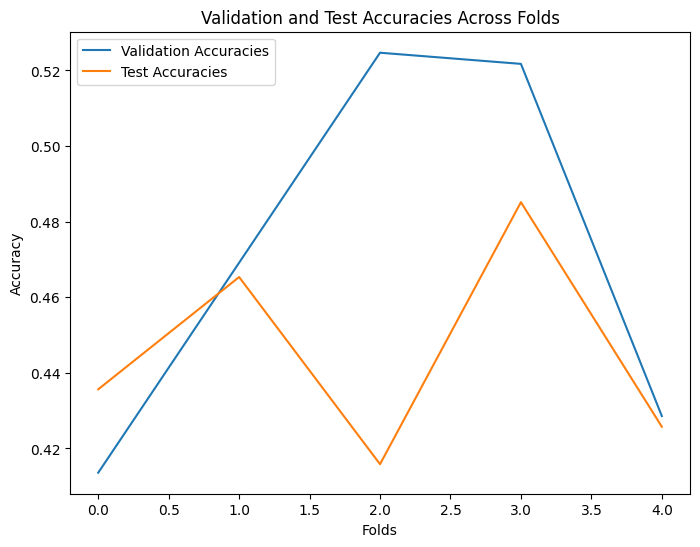

In [111]:
# Visualize validation and test accuracies
plt.figure(figsize=(8, 6))
plt.plot(val_accuracies_all, label='Validation Accuracies')
plt.plot(test_accuracies_all, label='Test Accuracies')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracies Across Folds')
plt.legend()
plt.show()

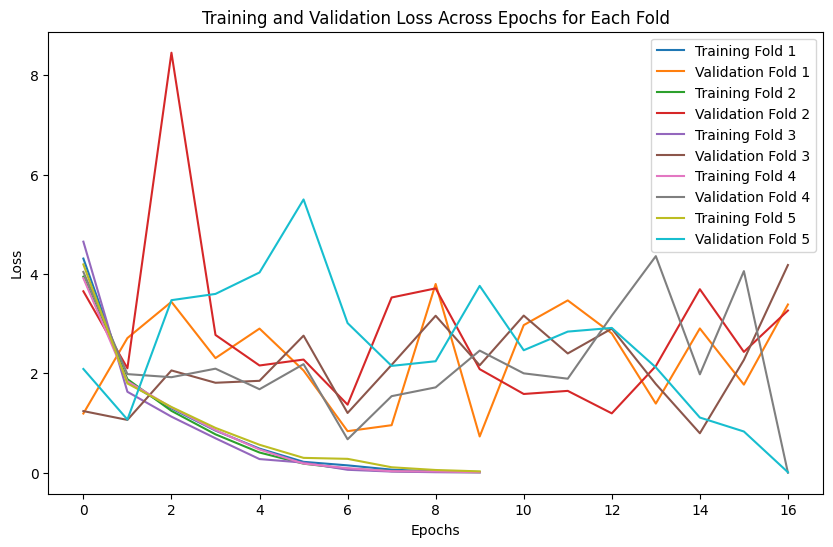

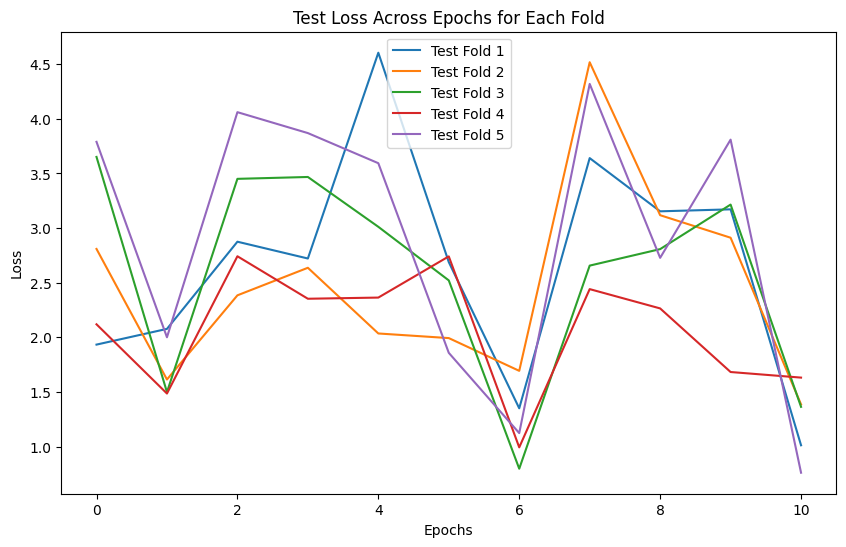

In [108]:
import matplotlib.pyplot as plt

# Visualize training and validation losses
plt.figure(figsize=(10, 6))
for fold in range(len(train_losses_all)):
    plt.plot(train_losses_all[fold], label=f'Training Fold {fold+1}')
    plt.plot(val_losses_all[fold], label=f'Validation Fold {fold+1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs for Each Fold')
plt.legend()
plt.show()

# Visualize test losses
plt.figure(figsize=(10, 6))
for fold in range(len(test_losses_all)):
    plt.plot(test_losses_all[fold], label=f'Test Fold {fold+1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Across Epochs for Each Fold')
plt.legend()
plt.show()


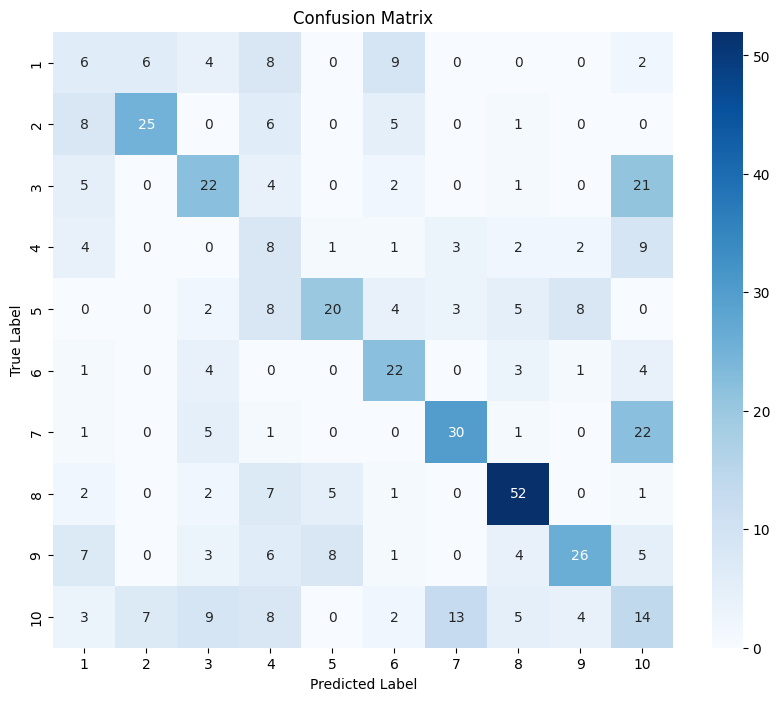

In [112]:
# Define class numbers corresponding to genre encodings
class_numbers = range(1, 11)  # Assuming 10 classes (1-10)

# Calculate confusion matrix for test set
cm = confusion_matrix(np.concatenate(test_labels_all), np.concatenate(test_predictions_all))

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_numbers, yticklabels=class_numbers)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [113]:
import pandas as pd

# Create a DataFrame for validation and test accuracies
accuracy_data = {
    'Validation Accuracies': val_accuracies_all,
    'Test Accuracies': test_accuracies_all
}
accuracy_df = pd.DataFrame(accuracy_data)
print("Validation and Test Accuracies Table:")
print(accuracy_df)


Validation and Test Accuracies Table:
   Validation Accuracies  Test Accuracies
0               0.413580         0.435644
1               0.469136         0.465347
2               0.524691         0.415842
3               0.521739         0.485149
4               0.428571         0.425743


In [119]:
import pandas as pd
import numpy as np

# Check the lengths of each training and validation loss array
train_lengths = [len(loss) for loss in train_losses_all]
val_lengths = [len(loss) for loss in val_losses_all]

# Determine the maximum length among all training and validation loss arrays
max_train_length = max(train_lengths)
max_val_length = max(val_lengths)
max_length = max(max_train_length, max_val_length)

# Pad or truncate each training and validation loss array to the maximum length
padded_train_losses = [np.concatenate([loss, [None] * (max_length - len(loss))]) for loss in train_losses_all]
padded_val_losses = [np.concatenate([loss, [None] * (max_length - len(loss))]) for loss in val_losses_all]

# Create a DataFrame for training and validation losses
loss_data = {}
for fold in range(len(padded_train_losses)):
    loss_data[f'Training Fold {fold+1}'] = padded_train_losses[fold]
    loss_data[f'Validation Fold {fold+1}'] = padded_val_losses[fold]
loss_df = pd.DataFrame(loss_data)
print("\nTraining and Validation Losses Table:")
print(loss_df)




Training and Validation Losses Table:
   Training Fold 1  Validation Fold 1 Training Fold 2  Validation Fold 2  \
0         4.309009           1.191256        3.945138           3.650571   
1         1.821177           2.709588        1.883096           2.102079   
2         1.294172           3.438806         1.24469           8.451246   
3         0.847884           2.306373        0.772476           2.772071   
4         0.484822           2.900077        0.406405           2.157851   
5         0.219052           2.057097        0.182151           2.277036   
6         0.147967           0.836404        0.079452           1.369465   
7         0.062122           0.956400        0.032305           3.525930   
8         0.025561           3.797868        0.015661           3.709705   
9         0.014505           0.729372        0.008837           2.083900   
10            None           2.969902            None           1.584444   
11            None           3.467560            

In [115]:
# Create a DataFrame for test losses
test_loss_data = {}
for fold in range(len(test_losses_all)):
    test_loss_data[f'Test Fold {fold+1}'] = test_losses_all[fold]
test_loss_df = pd.DataFrame(test_loss_data)
print("\nTest Losses Table:")
print(test_loss_df)



Test Losses Table:
    Test Fold 1  Test Fold 2  Test Fold 3  Test Fold 4  Test Fold 5
0      1.933246     2.808913     3.651174     2.119060     3.789191
1      2.077187     1.613860     1.498369     1.485444     2.000302
2      2.875112     2.384300     3.450469     2.741902     4.060826
3      2.721367     2.636476     3.467605     2.353034     3.869340
4      4.604938     2.035187     3.011454     2.363709     3.593673
5      2.688439     1.992897     2.520958     2.740696     1.857978
6      1.350240     1.693090     0.797413     0.992769     1.123216
7      3.640298     4.517828     2.656258     2.441142     4.319438
8      3.153237     3.117765     2.807283     2.264501     2.727411
9      3.171410     2.911612     3.214908     1.682357     3.809309
10     1.011801     1.385836     1.363582     1.631200     0.760585


In [116]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_numbers, columns=class_numbers)
print("\nConfusion Matrix Table:")
print(cm_df)



Confusion Matrix Table:
    1   2   3   4   5   6   7   8   9   10
1    6   6   4   8   0   9   0   0   0   2
2    8  25   0   6   0   5   0   1   0   0
3    5   0  22   4   0   2   0   1   0  21
4    4   0   0   8   1   1   3   2   2   9
5    0   0   2   8  20   4   3   5   8   0
6    1   0   4   0   0  22   0   3   1   4
7    1   0   5   1   0   0  30   1   0  22
8    2   0   2   7   5   1   0  52   0   1
9    7   0   3   6   8   1   0   4  26   5
10   3   7   9   8   0   2  13   5   4  14


In [ ]:
### Code that worked 4.25.24

# def train(model, train_loader, optimizer, criterion, epochs=10):
#     model.train()
#     train_losses = []
#     for epoch in range(epochs):
#         running_loss = 0.0
#         total_samples = 0  # Track total samples processed in each epoch
#         for batch_idx, (images, labels) in enumerate(train_loader):
#             images, labels = images.to(device), labels.to(device)  # Move data to GPU
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Calculate the actual batch size for this iteration
#             batch_size = len(images)

#             loss.backward()
#             optimizer.step()

#             # Update running loss and total samples
#             running_loss += loss.item() * batch_size
#             total_samples += batch_size

#         # Calculate average loss for the epoch
#         epoch_loss = running_loss / total_samples
#         train_losses.append(epoch_loss)
#         print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_loss}")

#     return train_losses

# def validate(model, val_loader, criterion):
#     model.eval()
#     correct = 0
#     total = 0
#     val_loss = 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     val_accuracy = correct / total
#     avg_val_loss = val_loss / len(val_loader)
#     return val_accuracy, avg_val_loss


# def test(model, test_loader, criterion):
#     model.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)  # Move data to GPU
#             outputs = model(images)